In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

data = spark.read.csv("kddcup.data_10_percent_corrected", header=True, inferSchema=True)

for col_name in data.columns:
    clean_col_name = col_name.replace('.', '_').replace(' ', '_')
    data = data.withColumnRenamed(col_name, clean_col_name)

numeric_features = [c for c, t in data.dtypes if t in ('int', 'double')]
for feature in numeric_features:
    data = data.withColumn(feature, col(feature).cast(DoubleType()))

imputer = Imputer(inputCols=numeric_features, outputCols=[f"{col}_imputed" for col in numeric_features])

assembler = VectorAssembler(inputCols=[f"{col}_imputed" for col in numeric_features], outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[imputer, assembler, scaler])

model = pipeline.fit(data)
transformed_data = model.transform(data)

transformed_data.show()


+---+---+----+---+-----+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+------+------+------+------+------+------+------+----+-----+------+------+----+------+------+------+------+------+-------+----------+-----------+------------+----------+----------+----------+----------+-----------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------+-----------+--------------+--------------+------------+--------------+--------------+--------------+--------------+--------------+--------------------+--------------------+
| 00|tcp|http| SF|  181|  5450| 06| 07| 08| 09|010|  1|012|013|014|015|016|017|018|019|020|021| 822| 823|0_0024|0_0025|0_0026|0_0027|1_0028|0_0029|0_0030| 931|  932|1_0033|0_0034|0_11|0_0036|0_0037|0_0038|0_0039|0_0040|normal_|00_imputed

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k = 3 
kmeans = KMeans(k=k, seed=1, featuresCol="scaled_features", predictionCol="cluster")


kmeans_model = kmeans.fit(transformed_data)


clustered_data = kmeans_model.transform(transformed_data)


clustered_data.show()


evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")


+---+---+----+---+-----+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+------+------+------+------+------+------+------+----+-----+------+------+----+------+------+------+------+------+-------+----------+-----------+------------+----------+----------+----------+----------+-----------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------+-----------+--------------+--------------+------------+--------------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------+
| 00|tcp|http| SF|  181|  5450| 06| 07| 08| 09|010|  1|012|013|014|015|016|017|018|019|020|021| 822| 823|0_0024|0_0025|0_0026|0_0027|1_0028|0_0029|0_0030| 931|  932|1_0033|0_0034|0_11|0_0036|0_0037|0_0038|0_0039|0_0040|normal_|00

Silhouette Score: 0.5689818962098162


In [9]:
from pyspark.sql.functions import col


centers = kmeans_model.clusterCenters()

def distance_from_center(features, center):
    return float(sum((features[i] - center[i]) ** 2 for i in range(len(features))) ** 0.5)


from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def calc_distance(features, cluster_id):
    return distance_from_center(features, centers[cluster_id])

distance_udf = udf(calc_distance, DoubleType())


clustered_data = clustered_data.withColumn("distance_from_center", 
                                           distance_udf(col("scaled_features"), col("cluster")))


threshold = 1.5


clustered_data = clustered_data.withColumn("is_anomaly", 
                                           col("distance_from_center") > threshold)

clustered_data.show()

+---+---+----+---+-----+------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+------+------+------+------+------+------+------+----+-----+------+------+----+------+------+------+------+------+-------+----------+-----------+------------+----------+----------+----------+----------+-----------+---------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------+-----------+--------------+--------------+------------+--------------+--------------+--------------+--------------+--------------+--------------------+--------------------+-------+--------------------+----------+
| 00|tcp|http| SF|  181|  5450| 06| 07| 08| 09|010|  1|012|013|014|015|016|017|018|019|020|021| 822| 823|0_0024|0_0025|0_0026|0_0027|1_0028|0_0029|0_0030| 931|  932|1_0033|0_0034|0_11|0_0036|0_0037

Number of anomalies: 482828
Total number of points: 494020
Anomaly percentage: 97.73%


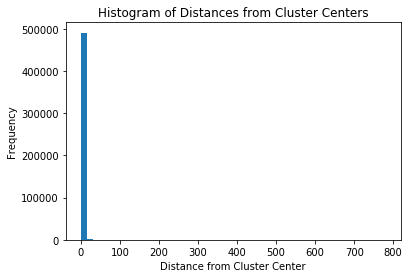

In [10]:

anomalies_count = clustered_data.filter(col("is_anomaly")).count()
total_count = clustered_data.count()

print(f"Number of anomalies: {anomalies_count}")
print(f"Total number of points: {total_count}")
print(f"Anomaly percentage: {100 * anomalies_count / total_count:.2f}%")

import matplotlib.pyplot as plt
import pandas as pd


pdf = clustered_data.select("distance_from_center").toPandas()

plt.hist(pdf["distance_from_center"], bins=50)
plt.xlabel("Distance from Cluster Center")
plt.ylabel("Frequency")
plt.title("Histogram of Distances from Cluster Centers")
plt.show()